In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils.fileutils import get_project_root

In [2]:
ROOT = get_project_root()
data_root = os.path.join(ROOT, 'data/raw')
audio_root = os.path.join(data_root, 'development_audio/development_audio')
annotations_root = os.path.join(data_root, 'development_annotation/development_annotation')

### MAESTRO contains 49 samples from 5 distinct environments/scenes

In [3]:
scenes = os.listdir(audio_root)

for scene in scenes:
    scene_path = os.path.join(audio_root, scene)
    n_samples = len(os.listdir(scene_path))
    print(f'{scene}: {n_samples} samples')

cafe_restaurant: 10 samples
city_center: 10 samples
grocery_store: 9 samples
metro_station: 9 samples
residential_area: 11 samples


### Each scene has a set of possible sound event labels

In [4]:
label_dict = {}
for scene in scenes:
    ann_path = os.path.join(annotations_root, f'soft_labels_{scene}')
    ann_files = os.listdir(ann_path)
    labels = []
    for file in ann_files:
        filepath = os.path.join(ann_path, file)
        df = pd.read_csv(filepath, header=None, delimiter='\t')
        file_labels = df[2].unique()
        for label in file_labels:
            if label not in labels:
                labels.append(label)
                
    label_dict[scene] = labels

In [5]:
df = pd.DataFrame(label_dict)
df

,cafe_restaurant,city_center,grocery_store,metro_station,residential_area
0,coffee machine,brakes_squeaking,announcement,door opens/closes,birds_singing
1,footsteps,large_vehicle,children voices,metro approaching,car
2,people talking,people talking,footsteps,metro leaving,children voices
3,cutlery and dishes,footsteps,people talking,people talking,people talking
4,furniture dragging,car,shopping cart,footsteps,footsteps
5,children voices,children voices,cash register beeping,children voices,wind_blowing


### Some labels/sound events occur across multiple scenes/settings

In [6]:
label_list = []
for vals in label_dict.values():
    for i in vals:
        if i not in label_list:
            label_list.append(i)

cat_dict = {}
for i in label_list:
    temp_list = []
    for col in df.columns:
        if i in list(df[col]):
            temp_list.append(col)
    cat_dict[i] = temp_list

pd.DataFrame(index=cat_dict.keys(), data=cat_dict.values())

,0,1,2,3,4
coffee machine,cafe_restaurant,None,None,None,None
footsteps,cafe_restaurant,city_center,grocery_store,metro_station,residential_area
people talking,cafe_restaurant,city_center,grocery_store,metro_station,residential_area
cutlery and dishes,cafe_restaurant,None,None,None,None
furniture dragging,cafe_restaurant,None,None,None,None
children voices,cafe_restaurant,city_center,grocery_store,metro_station,residential_area
brakes_squeaking,city_center,None,None,None,None
large_vehicle,city_center,None,None,None,None
car,city_center,residential_area,None,None,None
announcement,grocery_store,None,None,None,None


### Scene by scene analysis (Dominance of each label in each sample of each scene)

In [7]:
def get_annotations_df(annotation_filepath: str) -> pd.DataFrame:
    df = pd.read_csv(annotation_filepath, header=None, delimiter='\t')
    df = df.rename(columns={0: 'start', 1: 'end', 2: 'label', 3: 'confidence'})
    df = pd.pivot_table(df, values='confidence', index=['start', 'label']).reset_index()
    df = df.sort_values(by=['start', 'confidence'], ascending=[True, False]).reset_index(drop=True)
    return df

In [8]:
def plot_scene_dominance(scene):
    ann_path = os.path.join(annotations_root, f'soft_labels_{scene}')
    ann_files = os.listdir(ann_path)
    #print(ann_files)
    
    df = get_annotations_df(os.path.join(ann_path, ann_files[0]))
    grp = df.groupby('label')[['confidence']].sum()
    grp = grp.rename(columns={'confidence': ann_files[0]})
    for s in ann_files[1:]:
        df = get_annotations_df(os.path.join(ann_path, s))
        ngrp = df.groupby('label')[['confidence']].sum()
        ngrp = ngrp.rename(columns={'confidence': s})
        
        grp = grp.merge(ngrp, how='outer', left_index=True, right_index=True)
    
    grp.T.plot(kind='bar', title=scene)
    plt.show()
    plt.close()

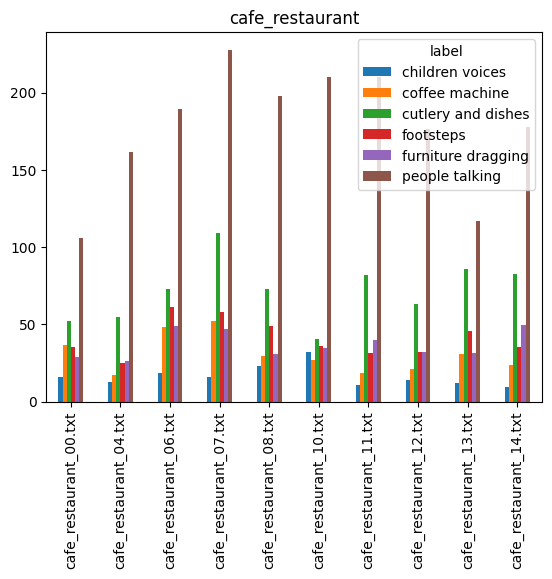

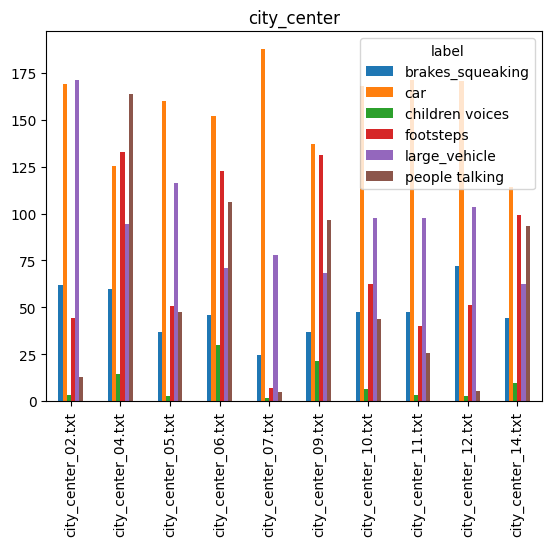

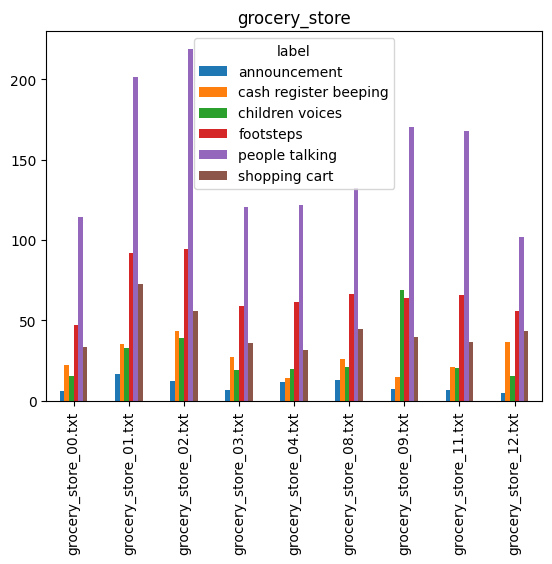

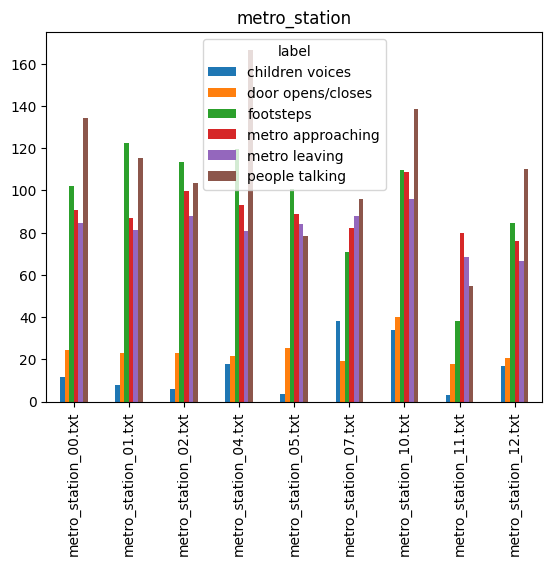

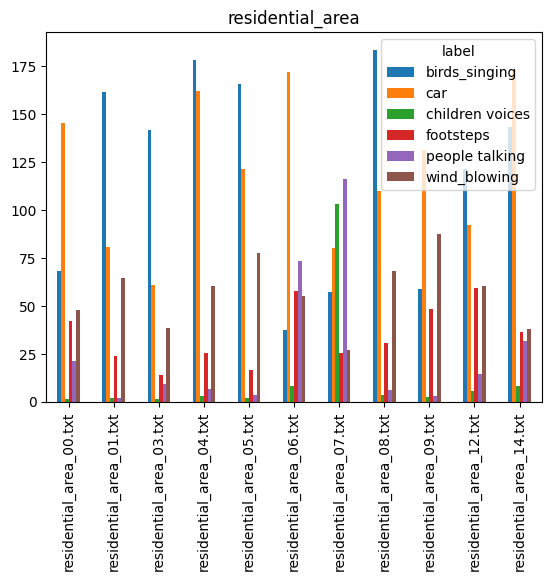

In [9]:
for scene in scenes:
    plot_scene_dominance(scene)